In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.utils.data import download_file
from astropy.io import fits  # We use fits to open the actual data file

from astropy.utils import data
data.conf.remote_timeout = 60

from spectral_cube import SpectralCube

from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS
from reproject import reproject_interp
from scipy.optimize import curve_fit
import matplotlib.patheffects as pe
import matplotlib as mpl
from astropy.table import Table

Created TAP+ (v20200428.1) - Connection:
	Host: sky.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
yso21=np.loadtxt('ysocs_in_gmc.txt',skiprows=1)[:,4]
yso16=np.loadtxt('ysocs_in_gmc.txt',skiprows=1)[:,5]
yso56=np.loadtxt('ysocs_in_gmc.txt',skiprows=1)[:,6]
yso21er=np.loadtxt('ysocs_in_gmc.txt',skiprows=1)[:,8]
yso56er=np.loadtxt('ysocs_in_gmc.txt',skiprows=1)[:,9]
yso16er=np.loadtxt('ysocs_in_gmc.txt',skiprows=1)[:,10]


mean21=np.mean(yso21)
bright=np.where(yso21>10*mean21)[0]
yso21[bright]=0
mid=np.where(yso21>2*mean21)[0]
yso21[mid]=0
dim=np.where(yso21>0)[0]
yso21=np.loadtxt('ysocs_in_gmc.txt',skiprows=1)[:,4]

In [3]:
modelpar = Table.read('spubsmi/parameters.fits')
index=np.where(modelpar['star.radius']>0)[0]

In [4]:
R17F21=np.loadtxt('model_flux_filters.txt',skiprows=1)[:,2][index]
R17F56=np.loadtxt('model_flux_filters.txt',skiprows=1)[:,0][index]
R17F16=np.loadtxt('model_flux_filters.txt',skiprows=1)[:,1][index]

In [5]:
modrad=modelpar['star.radius'][index]
modT=modelpar['star.temperature'][index]
modLstar=4*np.pi*(modrad*6.957e10)**2*(5.67e-5*modT**4)/3.8515e33
len(np.intersect1d(np.where(modrad<4)[0],np.where(modLstar>3)[0]))

76784

In [6]:
yso21er=np.loadtxt('ysocs_in_gmc.txt',skiprows=1)[:,8]+1
yso56er=np.loadtxt('ysocs_in_gmc.txt',skiprows=1)[:,9]+1
yso16er=np.loadtxt('ysocs_in_gmc.txt',skiprows=1)[:,10]+1

i=0
logl21=((yso21[i]-R17F21)**2/yso21er[i]**2)+np.log(yso21er[i]**2)
logl56=((yso56[i]-R17F56)**2/yso56er[i]**2)+np.log(yso56er[i]**2)
logl16=((yso16[i]-R17F16)**2/yso16er[i]**2)+np.log(yso16er[i]**2)
logL=-.5*(logl21+logl56+logl16)

In [7]:
max(logL)

-1.0917205998627946

In [8]:
biR1721=[]
biR1756=[]
biR1716=[]
for i in range(len(R17F21)):
    randindex=np.random.randint(0,len(R17F21))
    biR1721.append(R17F21[i]+R17F21[randindex])
    biR1756.append(R17F56[i]+R17F56[randindex])
    biR1716.append(R17F16[i]+R17F16[randindex])

In [9]:
i=0
logl21=((yso21[i]-biR1721)**2/yso21er[i]**2)+np.log(yso21er[i]**2)
logl56=((yso56[i]-biR1756)**2/yso56er[i]**2)+np.log(yso56er[i]**2)
logl16=((yso16[i]-biR1716)**2/yso16er[i]**2)+np.log(yso16er[i]**2)
logL=-.5*(logl21+logl56+logl16)

In [10]:
max(logL)

-0.7629876217708164

In [11]:
prostar=np.loadtxt('protostellar_evolution/ConstFormTime/m=200.0.txt',skiprows=1)

protime=prostar[:,0]/3.154e7
M0lis=np.logspace(-0.8672223601748673,np.log10(200),275)

In [97]:
M0lis=np.logspace(-0.8672223601748673,np.log10(200),275)
M0binwidth=np.logspace(-0.8672223601748673,2.3115577889448,276)[1:]\
            -np.logspace(-0.8672223601748673,np.log10(200),275)
comimf=np.concatenate(((M0binwidth[:50]*M0lis[:50]**-1.3)/sum(M0binwidth[:50]*M0lis[:50]**-1.3)\
                ,(M0binwidth[50:]*M0lis[50:]**-2.3)/sum(M0binwidth[50:]*M0lis[50:]**-2.3)))
mcdf=np.cumsum(comimf/sum(comimf))
tlis=np.linspace(1e4,3e5,1000)
tacc=3e5

tindexlis=[]
for i in range(len(tlis)):
    tindexlis.append(np.argmin(np.abs(protime-tlis[i])))
proLsmat=[]
proRmat=[]
for i in range(275):
    prostar=np.loadtxt('protostellar_evolution/ConstFormTime/m='+\
                       str(np.round(M0lis[i],3))+'.txt',skiprows=1)
    proLstar=prostar[:,6]
    prorad=prostar[:,3]
    proLsmat.append(proLstar[tindexlis])
    proRmat.append(prorad[tindexlis])

In [99]:
pM0=[]
pt=[]
pRt=[]
pLt=[]
trial=50000000
for i in range(trial):
    Mindex=np.argmin(np.abs(mcdf-np.random.rand()))
    M0=M0lis[Mindex]
    proLstar=proLsmat[Mindex]
    prorad=proRmat[Mindex]
    tindex=np.argmin(np.abs(tlis-np.random.rand()*3e5))
    t=tlis[tindex]
    if proLstar[tindex]!=0 and prorad[tindex]!=0:
        pM0.append(M0)
        pt.append(t)
        pLt.append(proLstar[tindex])
        pRt.append(prorad[tindex])

In [100]:
possRt=[]
possLstar=[]
for i in range(len(M0lis)):
    for j in range(len(tlis)):
        M0=M0lis[i]
        t=tlis[j]
        proLtot=proLsmat[i]
        possLstar.append(proLtot[j])
        prorad=proRmat[i]
        possRt.append(prorad[j])

In [101]:
pM0=np.array(pM0)
pLt=np.array(pLt)
pRt=np.array(pRt)

In [102]:
Ltgrid=np.logspace(np.log10(possLstar[np.searchsorted(possLstar,0,'right')])\
                   ,np.log10(np.max(possLstar))+0.1,101)
Rtgrid=np.logspace(np.log10(possRt[np.searchsorted(possRt,0,'right')]),\
                   np.log10(np.max(possRt))+0.1,101)
imgrid=[]
M0grid=[]
for i in range(len(Rtgrid)-1):
    imrow=[]
    M0row=[]
    rtmin=Rtgrid[i]
    rtmax=Rtgrid[i+1]
    rtrange=np.intersect1d(np.where(pRt>rtmin)[0],np.where(pRt<rtmax)[0])
    indexedpLt=pLt[rtrange]
    indexedpM0=pM0[rtrange]
    for j in range(len(Ltgrid)-1):
        ltmin=Ltgrid[j]
        ltmax=Ltgrid[j+1]
        ltrange=np.intersect1d(np.where(indexedpLt>ltmin)[0],np.where(indexedpLt<ltmax)[0])
        imrow.append(len(ltrange))
        M0row.append(indexedpM0[ltrange])
    imgrid.append(imrow)
    M0grid.append(M0row)

In [103]:
probgrid=np.array(imgrid)/trial
probgrid[np.where(probgrid==0)]=np.nan

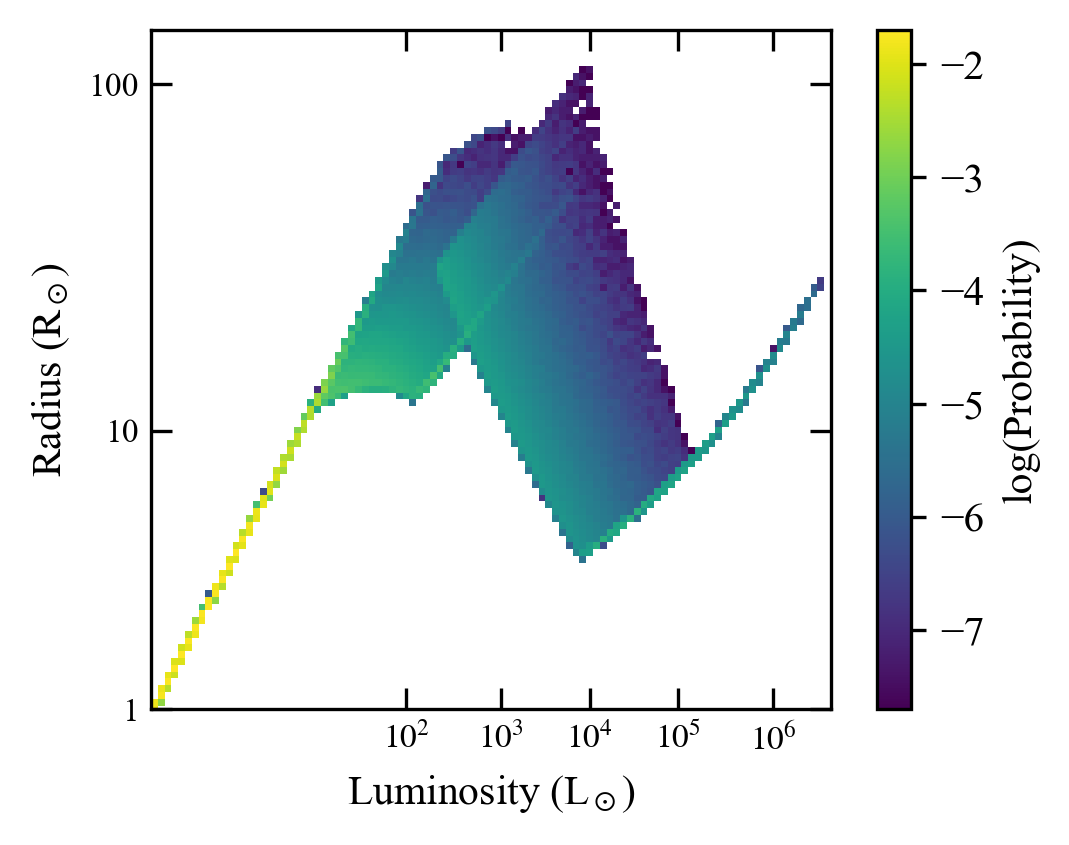

In [104]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(figsize=(4,3), facecolor= 'w', edgecolor ='k')
im=ax.imshow(np.log10(probgrid))
cbar=plt.colorbar(im)
cbar.set_label('log(Probability)')

ax.invert_yaxis()

ax.set_xticks([np.argmin(np.abs(Ltgrid-100)),np.argmin(np.abs(Ltgrid-1000))\
               ,np.argmin(np.abs(Ltgrid-10000)),np.argmin(np.abs(Ltgrid-100000)),\
               np.argmin(np.abs(Ltgrid-1000000))])
ax.set_xticklabels([r'$10^2$',r'$10^3$',r'$10^4$',r'$10^5$',r'$10^6$'])
ax.set_yticks([np.argmin(np.abs(Rtgrid-1)),np.argmin(np.abs(Rtgrid-10))\
               ,np.argmin(np.abs(Rtgrid-100))])
ax.set_yticklabels(['1','10','100'])
# ax.set_yticks([18,57,99])
# ax.set_yticklabels(['10','30','100'])
# ax.set_xlim(37,100)
ax.set_ylim(0,100)
ax.set_ylabel(r'Radius (R$_\odot$)')
ax.set_xlabel(r'Luminosity (L$_\odot$)')
ax.tick_params(axis="y",direction="in", pad=3,labelsize=8,which='major')
ax.tick_params(axis="x",direction="in", pad=3,labelsize=8,which='major')
ax.tick_params(top=True, right=True,length=5,which='major')
ax.tick_params(axis="y",direction="in", pad=3,labelsize=8,which='minor')
ax.tick_params(axis="x",direction="in", pad=3,labelsize=8,which='minor')
ax.tick_params(top=True, right=True,length=2,which='minor')

In [106]:
len(modLstar)

335388

In [107]:
modRLprob=[]
modM0lis=[]
modRsaved=[]
modLsaved=[]
for i in range(len(modrad)):
    modelrow=[]
    modelM0row=[]
    Lindex=np.argmin(np.abs(modLstar[i]-Ltgrid))-1
    Rindex=np.argmin(np.abs(modrad[i]-Rtgrid))-1
    modRsaved.append(Rtgrid[Rindex])
    modLsaved.append(Ltgrid[Lindex])
    modRLprob.append(probgrid[Rindex][Lindex])
    modM0lis.append(M0grid[Rindex][Lindex])

In [108]:
deletein=np.where(np.isnan(np.array(modRLprob)))[0]
modRLprob=np.delete(np.array(modRLprob),deletein)
modM0lis=np.delete(np.array(modM0lis),deletein)
modRsaved=np.delete(np.array(modRsaved),deletein)
modLsaved=np.delete(np.array(modLsaved),deletein)

<ipython-input-108-d9ec2eac0c4b>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  modM0lis=np.delete(np.array(modM0lis),deletein)


In [109]:
modM0lisstd=[]
modM0lismean=[]
for i in range(len(modM0lis)):
    modM0lisstd.append(np.std(modM0lis[i]))
    modM0lismean.append(np.mean(modM0lis[i]))

In [110]:
np.mean(modM0lisstd)

3.917990822845125

(0.1, 210)

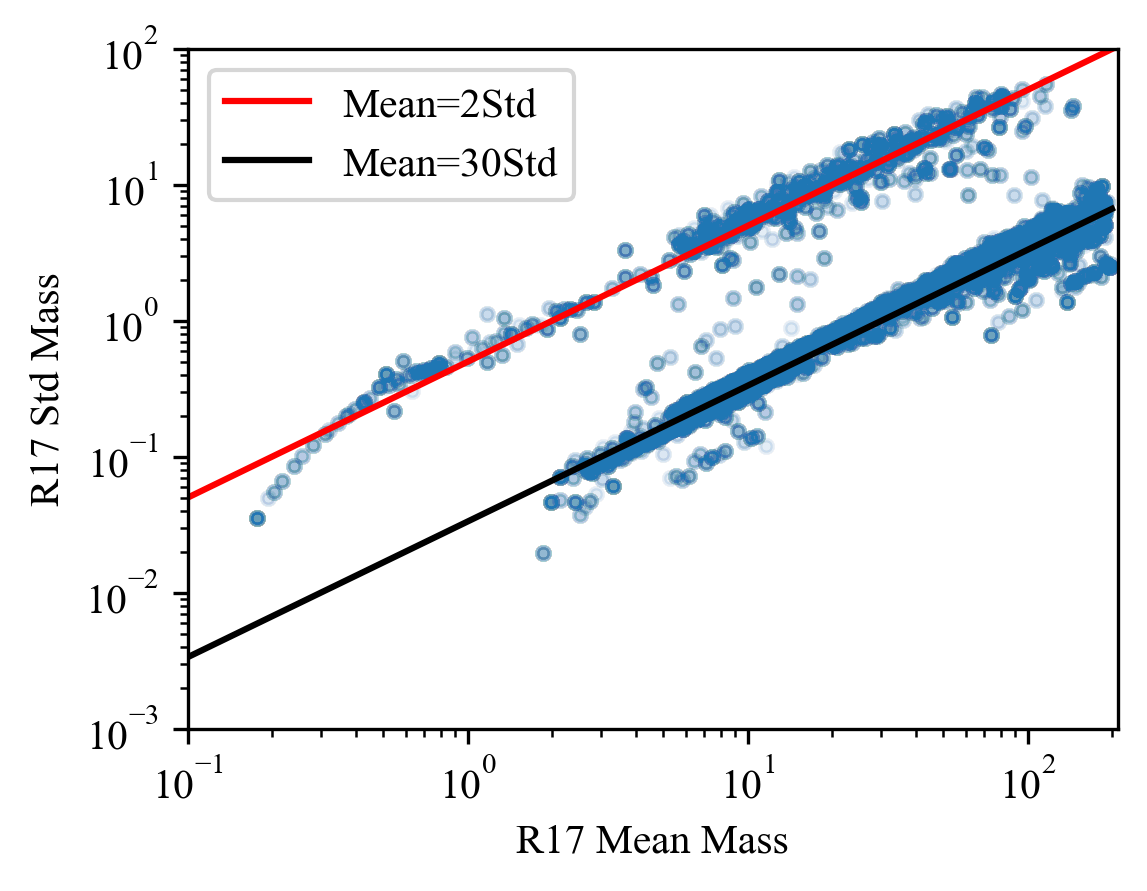

In [122]:
fig, ax = plt.subplots(figsize=(4,3), facecolor= 'w', edgecolor ='k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.scatter(modM0lismean,modM0lisstd,marker='.',alpha=0.01)
x=np.linspace(0,200)
ax.plot(x,x/2,color='r',label='Mean=2Std')
ax.plot(x,x/30,color='k',label='Mean=30Std')

ax.set_xlabel('R17 Mean Mass')
ax.set_ylabel('R17 Std Mass')
ax.legend()
ax.set_ylim(0.001,100)
ax.set_xlim(0.1,210)

In [112]:
badstdin=np.where(np.array(modM0lismean)/np.array(modM0lisstd)<10)[0]

<ipython-input-112-201e3a2e6a9e>:1: RuntimeWarning: divide by zero encountered in true_divide
  badstdin=np.where(np.array(modM0lismean)/np.array(modM0lisstd)<10)[0]


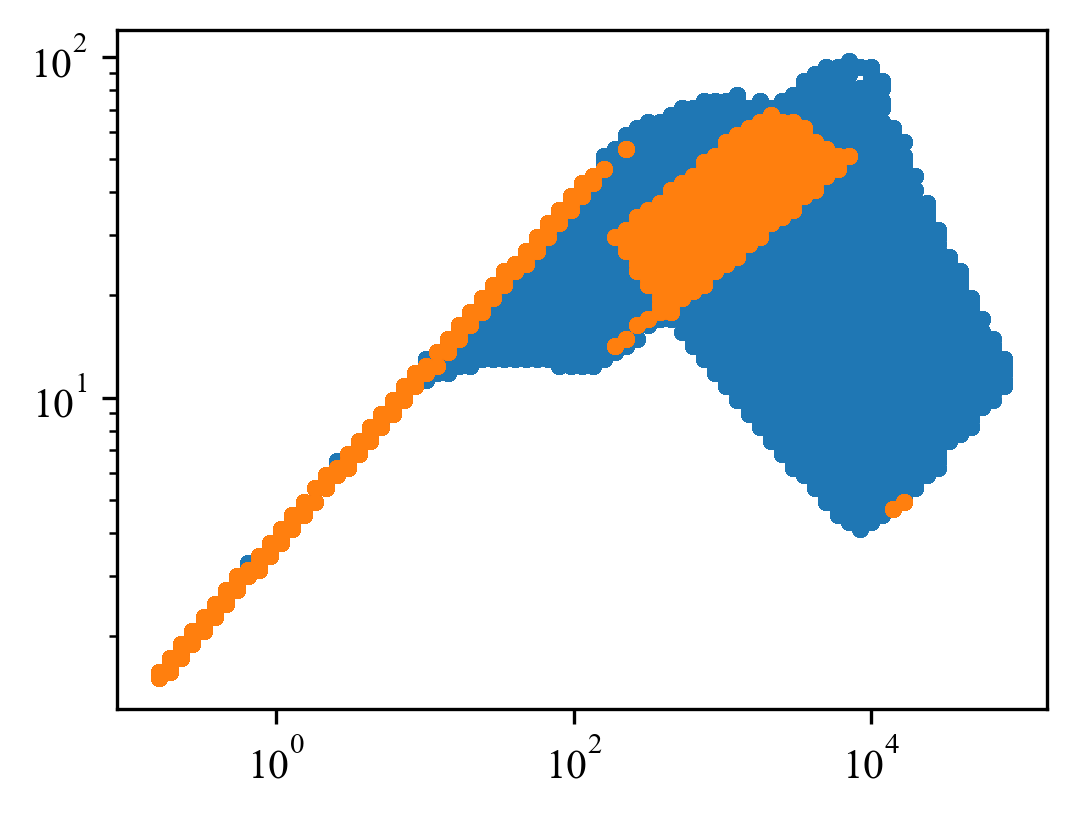

In [113]:
fig, ax = plt.subplots(figsize=(4,3), facecolor= 'w', edgecolor ='k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.scatter(modLsaved,modRsaved,marker='.')
ax.scatter(modLsaved[badstdin],modRsaved[badstdin],marker='.')